### Install Libraries

This cell installs necessary libraries for the project, including `openpyxl` for reading Excel files and `shap` for model interpretability.

In [ ]:
!pip install openpyxl shap

### Import Libraries

This cell imports all the required libraries for data manipulation, visualization, modeling, and logging.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
import datetime
import logging
import sys
import warnings
import shap

# Suppress specific warnings for cleaner logs if desired
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Logger Setup

This cell configures a logger to record the analysis process, including information, warnings, and errors. The logs are directed to both the console output and a combined log file.

In [ ]:
# --- Logger Setup ---

# *** Define the SINGLE log file path HERE ***
log_directory = Path("output_combined_log")
log_directory.mkdir(parents=True, exist_ok=True)
combined_log_filepath = log_directory / "full_analysis_run_log.txt" # Give it a descriptive name

# Clear existing handlers to avoid duplicates if re-running in notebook
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure basic logging to console AND the single file
logging.basicConfig(
    level=logging.INFO, # Capture info, warning, error
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler(combined_log_filepath, mode='w', encoding='utf-8'), # Log to file ('w' overwrites)
        logging.StreamHandler(sys.stdout) # Log to console
    ]
)
logger = logging.getLogger() # Get the root logger
logger.info(f"--- Starting Analysis Run ---")
logger.info(f"Combined log output will be saved to: {combined_log_filepath}")


2025-10-28 15:19:09 - INFO - --- Starting Analysis Run ---
2025-10-28 15:19:09 - INFO - Combined log output will be saved to: output_combined_log/full_analysis_run_log.txt


### Core Functions: Data Loading and Cleaning

This function loads data from an Excel file, cleans column names, removes empty columns and rows with missing values in essential columns, and checks for duplicates.

In [ ]:
# --- 1. Core Functions ---

def load_and_clean_data(file_path, id_col_name):
    """Loads data FROM EXCEL, cleans columns, performs initial checks."""
    logger.info(f"Loading data from: {file_path}")
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = [str(c).strip().replace(" ", "_") for c in df.columns]
        df.rename(columns={col: id_col_name for col in df.columns if col.lower() == id_col_name.lower()}, inplace=True)
        df.rename(columns={col: 'Por' for col in df.columns if col.lower() == 'por'}, inplace=True)
        df.rename(columns={col: 'Nu' for col in df.columns if col.lower() == 'nu'}, inplace=True)

        numeric_cols = [id_col_name, 'Por', 'Nu']
        for col in numeric_cols:
            if col in df:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            else:
                raise KeyError(f"Expected column '{col}' not found after cleaning.")

        initial_rows = len(df)
        df.dropna(subset=numeric_cols, inplace=True)
        rows_dropped = initial_rows - len(df)
        if rows_dropped > 0:
            logger.info(f"Dropped {rows_dropped} rows containing NaN values in essential columns.")

        duplicates = df.duplicated().sum()
        if duplicates > 0:
            logger.warning(f"Found {duplicates} duplicate rows. Dropping.")
            df.drop_duplicates(inplace=True)
            logger.info(f"Dropped {duplicates} duplicate rows.")

        logger.info("\n--- Initial Data Check ---")
        logger.info(f"Final Dataset Dimension: {df.shape}")
        logger.info(f"Columns: {df.columns.tolist()}")
        logger.info(f"\nData Types:\n{df.dtypes.to_string()}")
        logger.info(f"\nMissing values sum: {df.isna().sum().sum()}")
        logger.info(f"Duplicated rows: {df.duplicated().sum()}")
        logger.info(f"\nFirst 5 rows:\n{df.head().to_string()}")
        logger.info("-" * 30)
        return df

    except FileNotFoundError:
        logger.error(f"Error: File not found at {file_path}")
        return None
    except KeyError as e:
         logger.error(f"Error: Missing expected column after cleaning: {e}")
         return None

    except Exception as e:
        logger.exception(f"Failed to load data from {file_path}: {e}") # Use logger.exception here
        return None

### Preprocessing: Explore Data

This function performs Exploratory Data Analysis (EDA). It generates histograms for core numeric columns, a pairplot to visualize relationships between these columns, and a correlation heatmap to show the linear relationships between all core numeric features.

In [ ]:
# --- Preprocessing: Explore Data ---

def perform_eda(df, id_col_name, target_col='Nu'):
    logger.info("\n--- Performing EDA ---")
    core_numeric_cols = [col for col in [id_col_name, 'Por', target_col] if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

    if not core_numeric_cols:
        logger.warning("No core numeric columns found for EDA.")
        logger.info("-" * 30)
        return

    try:
        # --- Histograms ---
        logger.info("Generating histograms for core numeric columns...")
        for col in core_numeric_cols:
            plt.figure(figsize=(6, 4))
            sns.histplot(df[col], kde=True) # Use seaborn for a slightly nicer look with KDE
            plt.title(f'Distribution of {col} - {id_col_name} Dataset')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.show()
        # --- End Histograms ---

        logger.info("Generating pairplot...")
        # Ensure only existing core numeric columns are passed to pairplot
        sns.pairplot(df[core_numeric_cols])
        plt.suptitle(f'Pairplot - {id_col_name} Dataset (Core)', y=1.02)
        plt.show()

        logger.info("Generating correlation heatmap...")
        # Correlation already uses the core_numeric_cols list logic
        corr = df[core_numeric_cols].corr()
        plt.figure(figsize=(6, 4))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title(f"Correlation Matrix - {id_col_name} Dataset (Core)")
        plt.show()
        if target_col in corr:
            logger.info(f"\nCorrelations with {target_col}:\n" + corr[target_col].sort_values(ascending=False).to_string())

    except Exception as e:
        logger.error(f"An error occurred during EDA: {e}", exc_info=True) # Add exc_info for traceback
    logger.info("-" * 30)

### Feature Engineering

This function creates new features based on the existing ones. It includes log transformations for the ID column, 'Por', and the target variable ('Nu'), as well as interaction terms between the ID column and 'Por'. It also generates a correlation heatmap for all features, including the newly engineered ones.

In [ ]:
# --- 3. Feature Engineering ---

def engineer_features(df, id_col_name, target_col='Nu'):
    logger.info("\n--- Engineering Features ---")
    df_eng = df.copy()
    id_log_col = f"{id_col_name}_log"
    target_log_col = f"{target_col}_log"
    try:
        # ... (Log transform logic with checks for non-positive values using logger.warning) ...
        # Log transforms (with check for non-positive values)
        for col, log_col_name in [(id_col_name, id_log_col), ('Por', 'Por_log'), (target_col, target_log_col)]:
             if (df_eng[col] <= 0).any():
                 logger.warning(f"Non-positive values found in '{col}'. Adding 1e-9 before log.")
                 df_eng[log_col_name] = np.log(df_eng[col] + 1e-9)
             else:
                 df_eng[log_col_name] = np.log(df_eng[col])

        # Interaction terms
        df_eng['1_minus_Por'] = 1 - df_eng['Por']
        if (df_eng['1_minus_Por'] <= 0).any():
            logger.warning("Non-positive values found in '1_minus_Por'. Adding 1e-9 before log.")
            df_eng['1_minus_Por_log'] = np.log(df_eng['1_minus_Por'] + 1e-9)
        else:
            df_eng['1_minus_Por_log'] = np.log(df_eng['1_minus_Por'])

        df_eng[f"{id_col_name}_Por"] = df_eng[id_col_name] * df_eng['Por']
        df_eng[f"{id_col_name}_1_minus_Por"] = df_eng[id_col_name] * df_eng['1_minus_Por']
        df_eng[f"{id_col_name}_Por_log"] = df_eng[id_log_col] * df_eng['Por_log']
        df_eng[f"{id_col_name}_1_minus_Por_log"] = df_eng[id_log_col] * df_eng['1_minus_Por_log']

        engineered_features_list = [col for col in df_eng.columns if col not in df.columns]
        logger.info(f"Engineered features created: {engineered_features_list}")

        logger.info("Generating correlation heatmap for ALL features...")
        corr_full = df_eng.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_full, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 8})
        plt.title(f"Full Correlation Matrix - {id_col_name} Dataset")
        plt.tight_layout()
        plt.show()

        logger.info("\nDataFrame with engineered features (head):\n" + df_eng.head().to_string())
        logger.info("-" * 30)
        return df_eng, corr_full
    except Exception as e:
        logger.error(f"An error occurred during feature engineering: {e}")
        return df, pd.DataFrame()

### Feature Selection based on Correlation

This function selects features based on their absolute correlation with the target variable, using a specified threshold.

In [ ]:
# --- 2.2 Feature Selection based on correlation criteria ---

def select_features_based_on_correlation(corr_matrix, target_col, threshold=0.4):
    """Selects features based on absolute correlation with the target."""
    logger.info(f"\n--- Selecting Features based on Correlation with '{target_col}' (Threshold >= {threshold}) ---")
    # ... (Implementation using logger) ...
    if target_col not in corr_matrix.columns:
        logger.warning(f"Target '{target_col}' not in correlation matrix columns. Returning empty list.")
        return []

    correlations = corr_matrix[target_col].abs().sort_values(ascending=False)
    # Exclude the Target amd log function
    exclude_cols = [target_col, target_col.replace('_log', ''), target_col + '_log']
    selected_features = [
        idx for idx, val in correlations.items()
        if val >= threshold and idx not in exclude_cols
    ]

    logger.info(f"Selected features: {selected_features}")
    logger.info("-" * 30)

    return selected_features

### Data Preparation for Modeling

This function prepares the data for machine learning models by splitting it into features (X) and the target variable (y). It then further splits the data into training, validation, and test sets.

In [ ]:
# --- 3. Data Preparation ---

def prepare_data_for_modeling(df, features_list, target_col):
    """Splits data into X, y and then train/val/test sets."""
    logger.info("\n--- Preparing Data for Modeling ---")
    try:
        if not features_list:
             raise ValueError("Feature list cannot be empty for modeling.")
        X = df[features_list].astype(float)
        y = df[target_col].astype(float)

        if y.ndim != 1: y = y.squeeze()

        logger.info(f"Using Features: {features_list}")
        logger.info(f"Using Target: {target_col}")

        X_trainval, X_test, y_trainval, y_test = train_test_split(
            X, y, test_size=0.15, random_state=42
        )
        val_size_fraction = 0.15 / (1 - 0.15)
        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval, test_size=val_size_fraction, random_state=42
        )

        logger.info(f"Train set size: {X_train.shape}, y_train shape: {y_train.shape}")
        logger.info(f"Validation set size: {X_val.shape}")
        logger.info(f"Test set size: {X_test.shape}")
        logger.info("-" * 30)
        return X_train, X_val, X_test, y_train, y_val, y_test

    except KeyError as e:
        logger.error(f"Error: Feature or target column '{e}' not found in DataFrame.")
        return None, None, None, None, None, None
    except ValueError as e:
        logger.error(f"Error preparing data: {e}")
        return None, None, None, None, None, None
    except Exception as e:
        logger.error(f"An error occurred during data splitting: {e}")
        return None, None, None, None, None, None

### Checking for Overfitting and Underfitting

This function diagnoses the model's fit by comparing the performance on the training and a comparison set (e.g., validation or test set). It helps identify potential overfitting or underfitting issues.

In [ ]:
# --- Checking for Overfitting and underfitting ---

def diagnose_fit(model, X_train, y_train, X_comp, y_comp,
                 metric_func=mean_absolute_error, metric_name='MAE',
                 use_log_target=False, set_name='Validation'):
    """Diagnoses model fit, returns errors and diagnosis string."""
    logger.info(f"\n--- Diagnosing Fit using {metric_name} ({set_name} Set) ---")
    diagnosis = "Undetermined"
    train_error = float('nan')
    comp_error = float('nan')
    try:
        pred_train = model.predict(X_train)
        pred_comp = model.predict(X_comp)
        train_error = metric_func(y_train, pred_train)
        comp_error = metric_func(y_comp, pred_comp)

        logger.info(f"Training {metric_name}:   {train_error:.6f}")
        logger.info(f"{set_name} {metric_name}: {comp_error:.6f}")

        error_ratio = comp_error / train_error if train_error > 1e-9 else float('inf')
        high_error_threshold = 0.01 if use_log_target else 0.5

        if train_error > high_error_threshold and comp_error > high_error_threshold:
            diagnosis = f"Potential Underfitting (Errors high on both sets: Train={train_error:.4f}, {set_name}={comp_error:.4f})"
        elif error_ratio > 2.5 and train_error < (comp_error / 3.5):
            diagnosis = f"Potential Overfitting (Train error much lower. Ratio: {error_ratio:.2f})"
        elif comp_error > train_error * 2.0:
            diagnosis = f"Likely Good Fit, but monitor {set_name} error (Ratio: {error_ratio:.2f})"
        else:
            diagnosis = f"Likely Good Fit (Errors low and close. Ratio: {error_ratio:.2f})"
        logger.info(f"Diagnosis: {diagnosis}")

    except Exception as e:
        logger.error(f"Error during fit diagnosis: {e}")
        diagnosis = f"Error in diagnosis: {e}"

    logger.info("-" * 30)
    # Return values needed for the report
    return {'train_error': float(train_error), 'comp_error': float(comp_error), 'diagnosis': diagnosis}


### Tuning and Training the Models

This function tunes and trains machine learning models using Randomized Search Cross-Validation. It evaluates the models on the validation set and returns the best model, its parameters, validation scores, and a fit diagnosis.

In [ ]:
# --- 4. Tuning and Training the models ---

def train_tune_evaluate_model(model_name, base_pipeline, param_dist, X_train, y_train, X_val, y_val, use_log_target):
    """Tunes model, evaluates on validation, returns best model, params, val scores, fit diagnosis."""
    logger.info(f"\n--- Training and Tuning {model_name} ---")

    model_results = { # Initialize results dictionary
        'best_params': None,
        'validation_scores': {'MAE': float('nan'), 'RMSE': float('nan'), 'R2': float('nan')}, # Initialize scores
        'fit_diagnosis_validation': {'train_error': float('nan'), 'comp_error': float('nan'), 'diagnosis': 'Not run'},
        'error': None
    }
    best_model = None # Initialize best_model outside try

    try:
        search = RandomizedSearchCV(
            base_pipeline, param_distributions=param_dist,
            n_iter=20, cv=5, scoring="neg_mean_absolute_error",
            random_state=42, n_jobs=-1, verbose=1
        )
        search.fit(X_train, y_train)

        best_model = search.best_estimator_
        best_params = search.best_params_
        model_results['best_params'] = best_params
        logger.info(f"\nBest {model_name} params: {best_params}")

        try:
            pred_val = best_model.predict(X_val)
            mae = mean_absolute_error(y_val, pred_val)
            rmse = np.sqrt(mean_squared_error(y_val, pred_val))
            r2 = r2_score(y_val, pred_val)

            val_scores = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
            model_results['validation_scores'] = {k: float(v) for k, v in val_scores.items()}

            logger.info(f"\n{model_name} Validation Scores:")
            logger.info(f"  MAE: {mae:.4f}")
            logger.info(f"  RMSE: {rmse:.4f}")
            logger.info(f"  R2: {r2:.4f}")

        except Exception as e_val:
            logger.error(f"Error during {model_name} validation evaluation: {e_eval}", exc_info=True)
            model_results['error'] = f"Validation Evaluation Error: {e_eval}"
            # Keep val_scores as NaN in model_resultsdel_results['validation_scores'] = {'MAE': float('nan'), 'RMSE': float('nan'), 'R2': float('nan')}

        # Fit Diagnosis on Validation
        if not model_results['error']: # Check if evaluation succeeded before diagnosing
             fit_diag_val_results = diagnose_fit(best_model, X_train, y_train, X_val, y_val,
                                                 metric_func=mean_absolute_error, metric_name='MAE',
                                                 use_log_target=use_log_target,
                                                 set_name='Validation')
             model_results['fit_diagnosis_validation'] = fit_diag_val_results
        else:
             # Update diagnosis if evaluation failed
             model_results['fit_diagnosis_validation']['diagnosis'] = 'Skipped due to evaluation error'

    except Exception as e_train:
        # Catch errors during RandomizedSearchCV or initial assignments
        logger.error(f"An error occurred during {model_name} training/tuning main block: {e_train}", exc_info=True)
        model_results['error'] = f"{model_name} Training/Tuning Error: {e_train}"
        best_model = None # Ensure model is None if training failed

    logger.info("-" * 30)
    # Return the model (could be None) and the results dictionary
    return best_model, model_results

### Optional: Formula Formulation Attempt

This function attempts to generate a formula for the trained model. It notes that direct formula extraction is complex for the models used (GBR, SVR, MLP).

In [ ]:
# --- Optional. Formular Formulation ---

def attempt_formula_generation(model, feature_names, model_name):
    """Attempts to generate a formula (limited for complex models)."""
    logger.info(f"\n--- Attempting Formula Generation for {model_name} ---")
    formula = "Formula extraction not directly supported for this model type."

    # Check if the model is a pipeline and extract the final estimator
    if isinstance(model, Pipeline):
        final_estimator = model.named_steps.get('model', None)
    else:
        final_estimator = model

    if final_estimator is None:
        formula = "Could not extract final estimator from pipeline."

    elif isinstance(final_estimator, (GradientBoostingRegressor, SVR, MLPRegressor)):
         formula = ("Direct formula extraction is complex for GBR/SVR/MLP. "
                   "Consider using symbolic regression (e.g., gplearn) for an approximation, "
                   "but it can be computationally intensive and may not find the exact formula.")

    logger.info(formula)
    logger.info("-" * 30)
    return formula


### Model Application: Final Evaluation, Prediction, and SHAP Analysis

This function performs the final evaluation of the best model on the test set, generates predictions, attempts formula extraction, runs SHAP analysis for model interpretability (excluding SVR), and saves the model, predictions, and relevant plots (residual and SHAP summary plots).

In [ ]:
# --- 5. Model Application ---

def final_evaluation_and_predict(best_model, model_name, X_trainval, y_trainval, X_test, y_test,
                                 feature_names, target_col, use_log_target, output_prefix): # output_prefix includes target type
    """Retrains, evaluates on test, attempts formula, runs SHAP, saves model/predictions/plots (conditionally residual), returns results dict."""
    logger.info(f"\n--- Final Evaluation & Report for Best Model: {model_name} (Target: {'log' if use_log_target else 'direct'}) ---")
    final_results = {}
    original_target_col = target_col.replace('_log','') # Should always be 'Nu'
    output_dir = Path(f"output_{output_prefix.split('_')[0]}") # Base dir e.g. output_reynolds
    output_dir.mkdir(parents=True, exist_ok=True)
    target_suffix = "_log" if use_log_target else "_direct" # Suffix indicating training target

    if best_model is None:
        logger.error(f"Cannot perform final evaluation for {output_prefix}: No best model provided.")
        final_results['error'] = "No best model provided for final evaluation."
        return final_results

    try:
        # Retrain
        best_model.fit(X_trainval, y_trainval)
        logger.info("Model retrained on Train+Validation data.")
        final_results['retrained_on_trainval'] = True

        # Fit Diagnosis on Test Set (using the trained target scale)
        fit_diag_test_results = diagnose_fit(best_model, X_trainval, y_trainval, X_test, y_test,
                                             metric_func=mean_absolute_error, metric_name='MAE',
                                             use_log_target=use_log_target,
                                             set_name='Test')
        final_results['fit_diagnosis_test'] = fit_diag_test_results

        # Predictions (on the trained target scale)
        pred_test_transformed = best_model.predict(X_test)

        # --- Convert predictions AND actual test values back to ORIGINAL Nu scale ---
        if use_log_target:
            pred_test_original_scale = np.exp(pred_test_transformed)
            y_test_original_scale = np.exp(y_test)
            logger.info("Test predictions and actual values inverse-transformed (np.exp) for metrics and plotting.")
        else:
            pred_test_original_scale = pred_test_transformed
            y_test_original_scale = y_test # Already on original scale
        # --- End Conversion --

        # Test Metrics (Calculated on Original Nu Scale)
        mae_test = mean_absolute_error(y_test_original_scale, pred_test_original_scale)
        rmse_test = np.sqrt(mean_squared_error(y_test_original_scale, pred_test_original_scale))
        r2_test = r2_score(y_test_original_scale, pred_test_original_scale)
        test_scores = {'MAE': mae_test, 'RMSE': rmse_test, 'R2': r2_test}
        final_results['test_scores_original_scale'] = {k: float(v) for k, v in test_scores.items()}

        logger.info(f"\n{model_name} Test Scores (Original Scale):")
        logger.info(f"  MAE: {mae_test:.4f}")
        logger.info(f"  RMSE: {rmse_test:.4f}")
        logger.info(f"  R2: {r2_test:.4f}")

        # --- Attempt Formula Generation (on the retrained best model) ---
        formula = attempt_formula_generation(best_model, feature_names, model_name)
        final_results['formula_attempt'] = formula
        # --- End Formula Attempt ---

        # --- Residual Plot (Using Original Nu Scale Data) - Conditional ---
        if model_name != 'SVR':
            logger.info(f"Generating Residual Plot for {model_name}...")
            residuals_test_original_scale = y_test_original_scale - pred_test_original_scale
            fig_residual, ax_residual = plt.subplots(figsize=(6, 4))
            ax_residual.scatter(pred_test_original_scale, residuals_test_original_scale, alpha=0.6)
            ax_residual.axhline(0.0, color="red", linestyle="--")
            ax_residual.set_xlabel(f"Predicted {original_target_col} (Original Scale)")
            ax_residual.set_ylabel(f"Residual (Actual - Predicted {original_target_col})")
            ax_residual.set_title(f"Residual Plot - {model_name} ({output_prefix} Test, Orig Scale)")
            residual_plot_filepath = output_dir / f"{output_prefix}_{model_name}_residual_plot{target_suffix}.png"
            plt.tight_layout()
            plt.savefig(residual_plot_filepath)
            logger.info(f"Residual plot saved to: {residual_plot_filepath}")
            plt.close(fig_residual) # Close plot after saving
            final_results['residual_plot_file'] = str(residual_plot_filepath)
        else:
            logger.info(f"Skipping Residual Plot generation because the best model is SVR.")
            final_results['residual_plot_file'] = "Skipped (SVR model)"
        # --- End Residual Plot ---

        # --- SHAP Analysis ---
        logger.info(f"\n--- Performing SHAP Analysis for {model_name} ---")
        shap_plot_filepath = None # Initialize filepath
        try:
            # Need to get the actual model step from the pipeline
            model_step = best_model.named_steps['model']
            preprocessor_step = best_model.named_steps['prep']

            # Transform the test data using the pipeline's preprocessor
            X_test_transformed = preprocessor_step.transform(X_test)
            if hasattr(X_test_transformed, "toarray"):
                 X_test_transformed_dense = X_test_transformed.toarray()
            else:
                 X_test_transformed_dense = X_test_transformed
            X_test_transformed_df = pd.DataFrame(X_test_transformed_dense, columns=feature_names, index=X_test.index)

            explainer = None
            shap_values = None

            # SHAP Explainers
            if model_name == 'GBR':
                explainer = shap.TreeExplainer(model_step)
                shap_values = explainer.shap_values(X_test_transformed_df)
            elif model_name in ['MLP', 'SVR']:
                 X_trainval_transformed = preprocessor_step.transform(X_trainval)
                 if hasattr(X_trainval_transformed, "toarray"):
                     X_trainval_transformed_dense = X_trainval_transformed.toarray()
                 else:
                      X_trainval_transformed_dense = X_trainval_transformed
                 background_data_sample = shap.sample(X_trainval_transformed_dense, 100)
                 explainer = shap.KernelExplainer(model_step.predict, background_data_sample)
                 shap_values = explainer.shap_values(X_test_transformed_dense)
            else:
                logger.warning(f"SHAP explainer not configured for model type: {model_name}. Skipping SHAP analysis.")

            if explainer and shap_values is not None:
                # Generate and save SHAP summary plot
                plt.figure()
                shap.summary_plot(shap_values, X_test_transformed_df, show=False)
                shap_plot_filepath = output_dir / f"{output_prefix}_{model_name}_shap_summary{target_suffix}.png"
                plt.tight_layout()
                plt.savefig(shap_plot_filepath)
                logger.info(f"SHAP summary plot saved to: {shap_plot_filepath}")
                plt.close()
                final_results['shap_plot_file'] = str(shap_plot_filepath)

        except ImportError:
            logger.warning("SHAP library not found. Skipping SHAP analysis. Please install it (`pip install shap`).")
            final_results['shap_plot_file'] = "SHAP library not found."
        except Exception as e_shap:
            logger.error(f"Error during SHAP analysis for {model_name}: {e_shap}", exc_info=True)
            final_results['shap_plot_file'] = f"Error: {e_shap}"
        # --- End SHAP Analysis ---

        # --- Save Outputs ---
        # (Saving logic remains the same, just ensure 'residual_plot_file' and 'shap_plot_file' keys are correctly handled in final_results)
        predictions_df = X_test.copy()
        predictions_df['Actual_' + original_target_col] = y_test_original_scale.values if isinstance(y_test_original_scale, pd.Series) else y_test_original_scale
        predictions_df['Predicted_' + original_target_col] = pred_test_original_scale

        pred_filename = output_dir / f"{output_prefix}_{model_name}_test_predictions{target_suffix}.csv"
        model_filename = output_dir / f"{output_prefix}_{model_name}_final_model{target_suffix}.joblib"
        metrics_filename = output_dir / f"{output_prefix}_{model_name}_test_metrics{target_suffix}.json"

        predictions_df.to_csv(pred_filename, index=False)
        joblib.dump(best_model, model_filename)
        serializable_test_scores = {k: float(v) for k, v in final_results['test_scores_original_scale'].items()}
        with open(metrics_filename, "w") as f:
             json.dump(serializable_test_scores, f, indent=2)

        final_results['predictions_file'] = str(pred_filename)
        final_results['model_file'] = str(model_filename)
        final_results['metrics_file'] = str(metrics_filename)
        # Ensure plot file paths are strings if they exist, otherwise indicate status
        if 'residual_plot_file' not in final_results: final_results['residual_plot_file'] = "Not generated"
        if 'shap_plot_file' not in final_results: final_results['shap_plot_file'] = "Not generated or error"


        logger.info(f"Predictions saved to: {pred_filename}")
        logger.info(f"Final model saved to: {model_filename}")
        logger.info(f"Test metrics saved to: {metrics_filename}")


    except Exception as e:
        logger.exception(f"An error occurred during final evaluation/prediction for {output_prefix}: {e}")
        final_results['error'] = f"Final Evaluation Error: {e}"

    logger.info("-" * 30)
    return final_results


### Configuration and Model Setup

This cell defines the configurations for the two datasets (Reynolds and Darcy) and sets up the base machine learning pipelines for Gradient Boosting Regressor (GBR), Multi-layer Perceptron (MLP) Regressor, and Support Vector Regressor (SVR). It also defines the hyperparameter search spaces for each model.

In [ ]:
# --- "___main___": Configurations ---

config_re = {
    'file_path': '/content/sample_data/Nu-Re-Por-Nu=1000.xlsx',
    'id_col': 'Re',
    'target_col': 'Nu',
    'use_log_target': True,
    # Define potential features; selection happens after correlation analysis
    'potential_features': ['Re', 'Por', 'Re_log', 'Por_log', '1_minus_Por', '1_minus_Por_log',
                           'Re_Por', 'Re_1_minus_Por', 'Re_Por_log', 'Re_1_minus_Por_log'],
    'output_prefix': 'reynolds'
}

config_da = {
    'file_path': '/content/sample_data/Nu-Da-Por-Nu=1000.xlsx',
    'id_col': 'Da',
    'target_col': 'Nu',
    'use_log_target': True,
    'potential_features': ['Da', 'Por', 'Da_log', 'Por_log', '1_minus_Por', '1_minus_Por_log',
                           'Da_Por', 'Da_1_minus_Por', 'Da_Por_log', 'Da_1_minus_Por_log'],
    'output_prefix': 'darcy'
}

configs_to_run = [config_re, config_da]
target_options = [True, False] # True for log(Nu), False for direct Nu

# --- 1. Preprocessing and Model Pipelines ---
num_cols = [] # Will be updated dynamically
preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="drop"
)
pipe_gbr_base = Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))])
pipe_mlp_base = Pipeline([("prep", preprocess), ("model", MLPRegressor(max_iter=1000, early_stopping=True, validation_fraction=0.15, random_state=42))]) # Added validation_fraction
pipe_svr_base = Pipeline([("prep", preprocess), ("model", SVR())])

# --- 2. Hyperparameter Search Spaces ---
param_dist_gbr = {
    "model__n_estimators": np.arange(150, 501, 50),
    "model__learning_rate": np.logspace(-2.0, -0.2, 6),
    "model__max_depth": [3, 4, 5, 6], # Slightly increased max_depth options
    "model__subsample": [0.7, 0.8, 0.9, 1.0], # Added 0.7, 0.9
    "model__min_samples_leaf": [1, 3, 5], # Reduced options
}

param_dist_mlp = {
    "model__hidden_layer_sizes": [(64,), (64, 32), (128,), (128, 64), (128, 64, 32)], # More options
    "model__activation": ["relu", "tanh"],
    "model__solver": ["adam"], # Adam often works well
    "model__learning_rate_init": np.logspace(-4, -2.5, 4), # Adjusted range
    "model__alpha": np.logspace(-5, -2, 4), # Adjusted range
    "model__batch_size": [32, 64, 'auto'] # Added batch size tuning
}

param_dist_svr = {
    "model__C": [1, 5, 10, 20, 50, 100], # Expanded C range
    "model__gamma": ['scale', 'auto', 0.1, 0.01, 0.001], # Refined gamma
    "model__kernel": ["rbf"], # RBF is often best, simplifying search
    'model__epsilon': [0.01, 0.05, 0.1, 0.2] # More epsilon options
}


### Workflow Orchestration

This cell orchestrates the entire machine learning workflow. It iterates through each dataset and each target option (log-transformed and direct). For each combination, it performs data loading, EDA, feature engineering, feature selection, data splitting, model training and tuning, and final evaluation with predictions and SHAP analysis. It also logs validation and test scores for comparison.

2025-10-28 15:19:09 - INFO - 
=============== PROCESSING DATASET: REYNOLDS ===============

2025-10-28 15:19:09 - INFO - Loading data from: /content/sample_data/Nu-Re-Por-Nu=1000.xlsx
2025-10-28 15:19:09 - INFO - 
--- Initial Data Check ---
2025-10-28 15:19:09 - INFO - Final Dataset Dimension: (4000, 3)
2025-10-28 15:19:09 - INFO - Columns: ['Re', 'Por', 'Nu']
2025-10-28 15:19:09 - INFO - 
Data Types:
Re     float64
Por    float64
Nu     float64
2025-10-28 15:19:09 - INFO - 
Missing values sum: 0
2025-10-28 15:19:09 - INFO - Duplicated rows: 0
2025-10-28 15:19:09 - INFO - 
First 5 rows:
       Re  Por       Nu
0  10.000  0.2  0.68776
1  10.991  0.2  0.75567
2  11.982  0.2  0.82351
3  12.973  0.2  0.89130
4  13.964  0.2  0.95901
2025-10-28 15:19:09 - INFO - ------------------------------
2025-10-28 15:19:09 - INFO - 
--- Performing EDA ---
2025-10-28 15:19:09 - INFO - Generating histograms for core numeric columns...


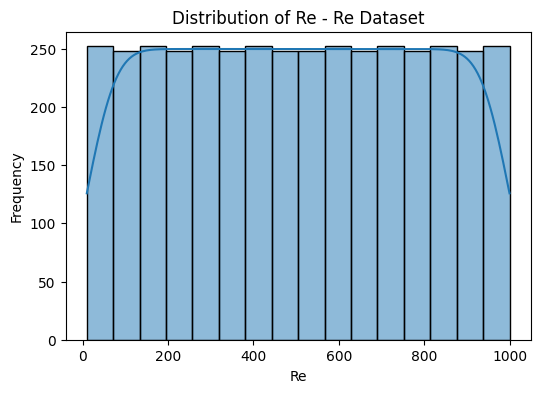

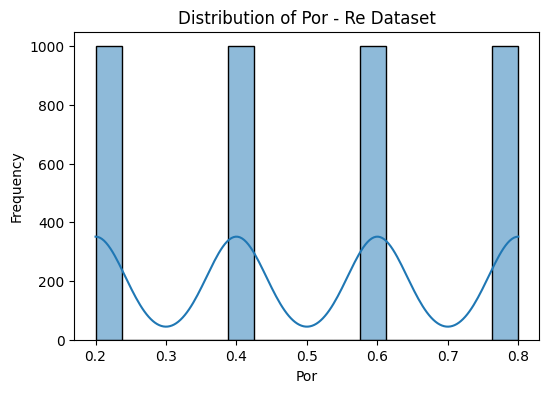

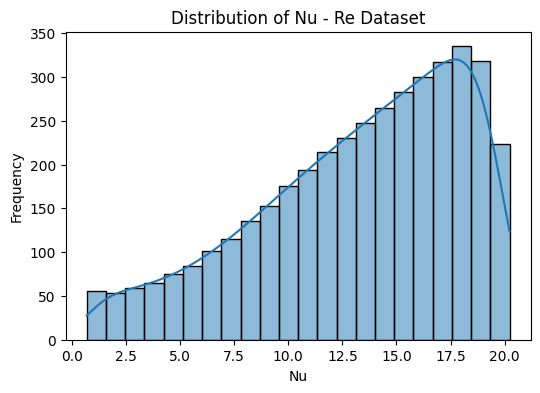

2025-10-28 15:19:10 - INFO - Generating pairplot...


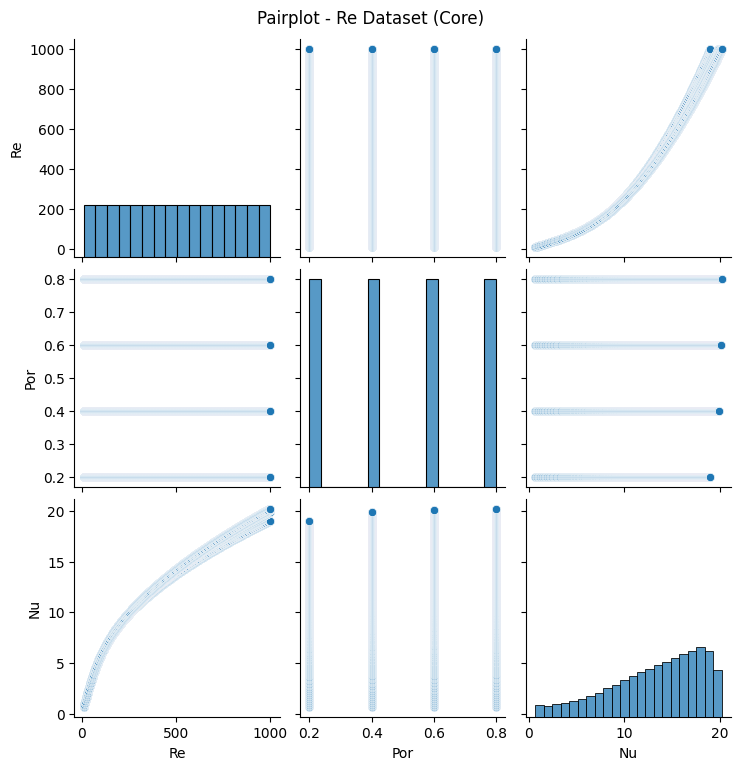

2025-10-28 15:19:12 - INFO - Generating correlation heatmap...


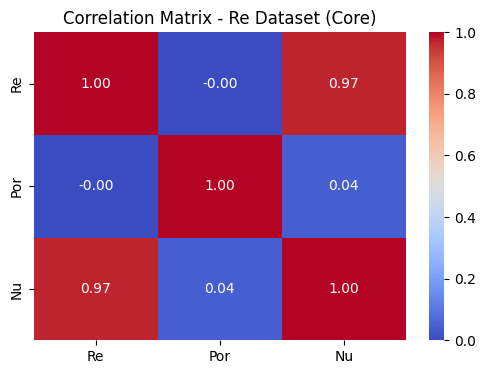

2025-10-28 15:19:13 - INFO - 
Correlations with Nu:
Nu     1.000000
Re     0.971082
Por    0.040315
2025-10-28 15:19:13 - INFO - ------------------------------
2025-10-28 15:19:13 - INFO - 
--- Engineering Features ---
2025-10-28 15:19:13 - INFO - Engineered features created: ['Re_log', 'Por_log', 'Nu_log', '1_minus_Por', '1_minus_Por_log', 'Re_Por', 'Re_1_minus_Por', 'Re_Por_log', 'Re_1_minus_Por_log']
2025-10-28 15:19:13 - INFO - Generating correlation heatmap for ALL features...


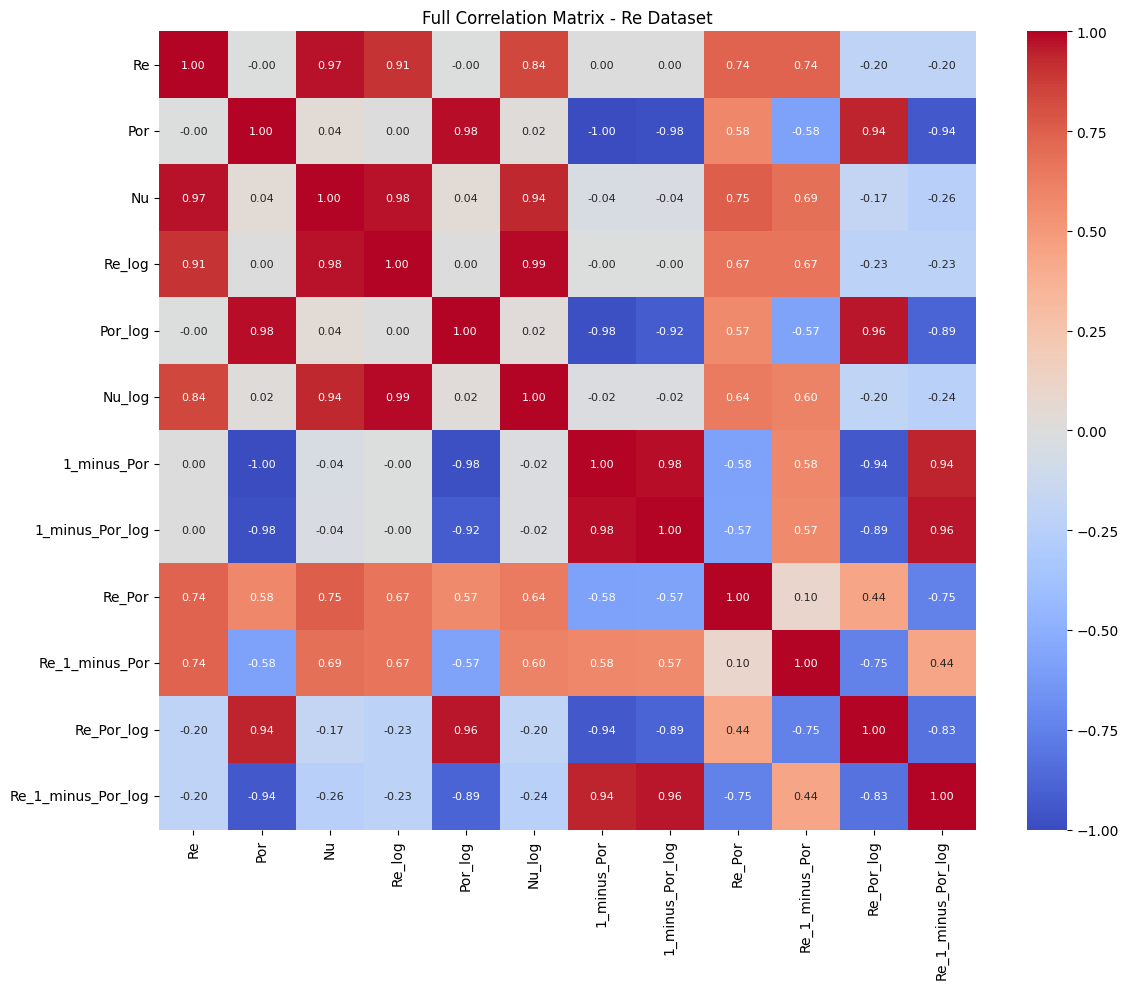

2025-10-28 15:19:14 - INFO - 
DataFrame with engineered features (head):
       Re  Por       Nu    Re_log   Por_log    Nu_log  1_minus_Por  1_minus_Por_log  Re_Por  Re_1_minus_Por  Re_Por_log  Re_1_minus_Por_log
0  10.000  0.2  0.68776  2.302585 -1.609438 -0.374315          0.8        -0.223144  2.0000          8.0000   -3.705868           -0.513807
1  10.991  0.2  0.75567  2.397077 -1.609438 -0.280151          0.8        -0.223144  2.1982          8.7928   -3.857946           -0.534892
2  11.982  0.2  0.82351  2.483406 -1.609438 -0.194180          0.8        -0.223144  2.3964          9.5856   -3.996887           -0.554156
3  12.973  0.2  0.89130  2.562870 -1.609438 -0.115074          0.8        -0.223144  2.5946         10.3784   -4.124781           -0.571888
4  13.964  0.2  0.95901  2.636483 -1.609438 -0.041854          0.8        -0.223144  2.7928         11.1712   -4.243255           -0.588314
2025-10-28 15:19:14 - INFO - ------------------------------
2025-10-28 15:19:14 - INFO 

  0%|          | 0/600 [00:00<?, ?it/s]

2025-10-28 15:30:19 - INFO - num_full_subsets = 2
2025-10-28 15:30:19 - INFO - np.sum(w_aug) = np.float64(3.999999999999999)
2025-10-28 15:30:19 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999998)
2025-10-28 15:30:19 - INFO - phi = array([ 1.01046446,  0.294448  , -0.90833019,  0.79120076])
2025-10-28 15:30:19 - INFO - num_full_subsets = 2
2025-10-28 15:30:19 - INFO - np.sum(w_aug) = np.float64(3.999999999999999)
2025-10-28 15:30:19 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999998)
2025-10-28 15:30:19 - INFO - phi = array([ 0.86847324, -0.04367689,  0.8330661 , -0.73674763])
2025-10-28 15:30:19 - INFO - num_full_subsets = 2
2025-10-28 15:30:19 - INFO - np.sum(w_aug) = np.float64(3.999999999999999)
2025-10-28 15:30:19 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999998)
2025-10-28 15:30:19 - INFO - phi = array([ 0.94370983,  0.14216055, -0.94732501,  0.70641895])
2025-10-28 15:30:19 - INFO - num_full_subsets = 2
2025-10-28 15:30:19 - I

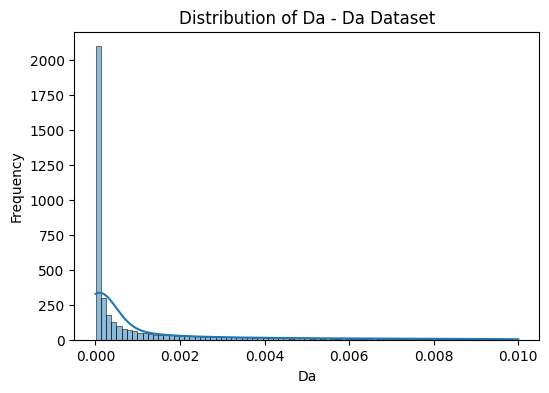

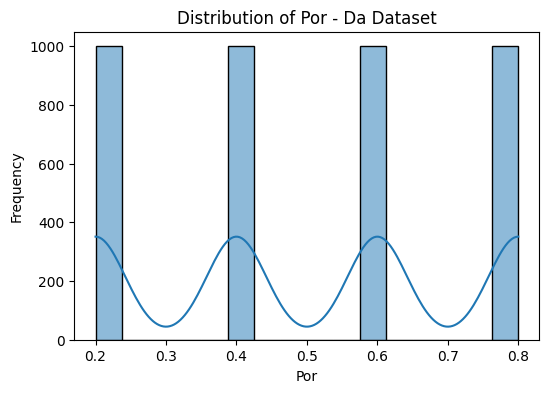

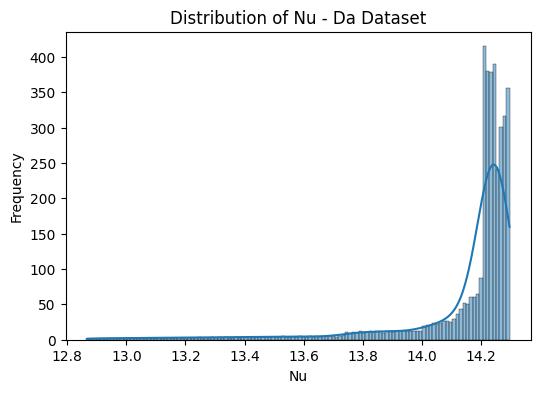

2025-10-28 15:30:45 - INFO - Generating pairplot...


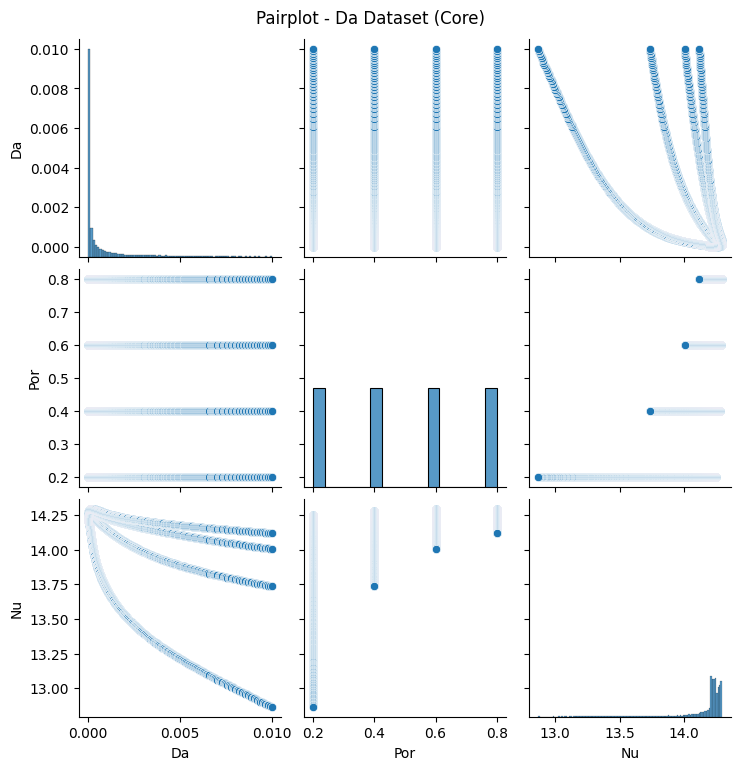

2025-10-28 15:30:47 - INFO - Generating correlation heatmap...


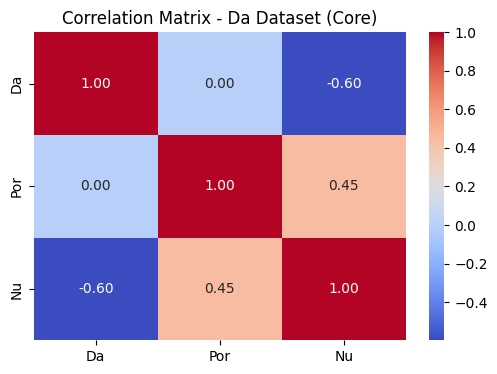

2025-10-28 15:30:47 - INFO - 
Correlations with Nu:
Nu     1.000000
Por    0.450531
Da    -0.598190
2025-10-28 15:30:47 - INFO - ------------------------------
2025-10-28 15:30:47 - INFO - 
--- Engineering Features ---
2025-10-28 15:30:47 - INFO - Engineered features created: ['Da_log', 'Por_log', 'Nu_log', '1_minus_Por', '1_minus_Por_log', 'Da_Por', 'Da_1_minus_Por', 'Da_Por_log', 'Da_1_minus_Por_log']
2025-10-28 15:30:47 - INFO - Generating correlation heatmap for ALL features...


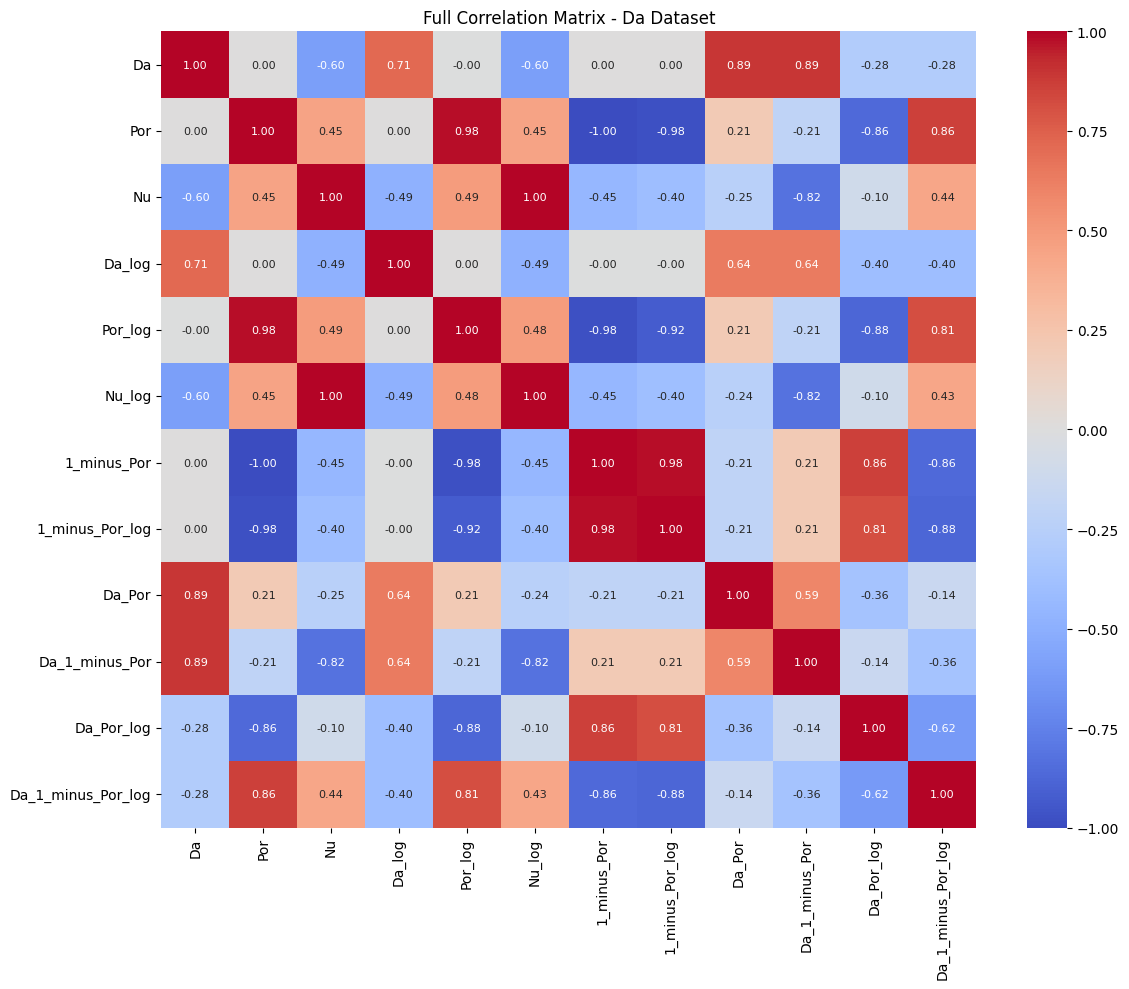

2025-10-28 15:30:48 - INFO - 
DataFrame with engineered features (head):
         Da  Por     Nu     Da_log   Por_log    Nu_log  1_minus_Por  1_minus_Por_log        Da_Por  Da_1_minus_Por  Da_Por_log  Da_1_minus_Por_log
0  0.000001  0.2  14.21 -13.815511 -1.609438  2.653946          0.8        -0.223144  2.000000e-07    8.000000e-07   22.235206            3.082842
1  0.000001  0.2  14.21 -13.806254 -1.609438  2.653946          0.8        -0.223144  2.018600e-07    8.074400e-07   22.220308            3.080776
2  0.000001  0.2  14.21 -13.797081 -1.609438  2.653946          0.8        -0.223144  2.037200e-07    8.148800e-07   22.205546            3.078730
3  0.000001  0.2  14.21 -13.787895 -1.609438  2.653946          0.8        -0.223144  2.056000e-07    8.224000e-07   22.190762            3.076680
4  0.000001  0.2  14.21 -13.778600 -1.609438  2.653946          0.8        -0.223144  2.075200e-07    8.300800e-07   22.175802            3.074606
2025-10-28 15:30:48 - INFO - ----------------

In [ ]:
# --- 6. Workflow Orchestration ---
all_final_test_scores = {}

for config in configs_to_run:
    logger.info(f"\n{'='*15} PROCESSING DATASET: {config['output_prefix'].upper()} {'='*15}\n")
    # *** No file handler management needed inside the loop ***

    df_current = load_and_clean_data(config['file_path'], config['id_col'])
    if df_current is None: continue

    perform_eda(df_current, config['id_col'], config['target_col'])

    df_featured, corr_full = engineer_features(df_current, config['id_col'], config['target_col'])
    if df_featured is None: continue

    # --- Loop through target options: log(Nu) and direct Nu ---
    for use_log in target_options:
        target_type_str = "log" if use_log else "direct"
        logger.info(f"\n{'~'*15} TARGET: {config['target_col']} ({target_type_str}) {'~'*15}\n")
        current_config = config.copy() # Avoid modifying original config
        current_config['use_log_target'] = use_log

        # Determine Target variable name for this run
        target_variable = f"{current_config['target_col']}_log" if current_config['use_log_target'] else current_config['target_col']

        # Select Features based on Correlation with the CURRENT target
        features_to_use = select_features_based_on_correlation(corr_full, target_variable, threshold=0.4)

        # Prepare Data
        X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_modeling(
            df_featured, features_to_use, target_variable
        )
        if X_train is None: continue # Skip this target type if splitting fails
        X_trainval = pd.concat([X_train, X_val])
        y_trainval = pd.concat([y_train, y_val])

        # Update preprocessor
        num_cols_current = features_to_use
        preprocess.transformers = [("num", StandardScaler(), num_cols_current)]

        # Train, Tune, Evaluate Models
        models_trained = {}
        validation_reports = {}
        models_to_run = {'GBR': (pipe_gbr_base, param_dist_gbr), 'MLP': (pipe_mlp_base, param_dist_mlp), 'SVR': (pipe_svr_base, param_dist_svr)}

        for name, (pipe, params) in models_to_run.items():
            best_model, model_report = train_tune_evaluate_model(
                name, pipe, params, X_train, y_train, X_val, y_val, current_config['use_log_target']
            )
            if best_model is not None: models_trained[name] = best_model
            validation_reports[name] = model_report

        valid_validation_scores = { name: report['validation_scores'] for name, report in validation_reports.items() if report and 'validation_scores' in report}
        if not valid_validation_scores:
            logger.warning("No models trained successfully to select the best.")
            best_model_name = None; best_final_model = None
        else:
            best_model_name = min(valid_validation_scores, key=lambda k: valid_validation_scores[k]['MAE'])
            best_final_model = models_trained.get(best_model_name)
            logger.info(f"\n>>> Best Model Selected for {current_config['output_prefix'].upper()} based on Validation MAE: {best_model_name} <<<")

        # Final Evaluation and Prediction for this target type
        output_prefix_with_target = f"{current_config['output_prefix']}_{target_type_str}"
        final_eval_results_dict = final_evaluation_and_predict(
            best_final_model, best_model_name, X_trainval, y_trainval, X_test, y_test,
            features_to_use, current_config['target_col'], current_config['use_log_target'],
            output_prefix_with_target # Pass combined prefix
        )
        result_key = f"{current_config['output_prefix']}_{best_model_name}_{target_type_str}" # Key for summary table
        all_final_test_scores[result_key] = final_eval_results_dict.get('test_scores_original_scale', {})

        # Log Comparison Table for THIS target type (Validation Scores)
        logger.info(f"\n--- Model Comparison Table ({current_config['output_prefix'].upper()} Validation Set, Target: {target_variable}) ---")
        logger.info("| Model | Val MAE | Val RMSE | Val R² |")
        logger.info("|---|---|---|---|")
        for name, report in validation_reports.items():
            if report and 'validation_scores' in report:
                scores = report['validation_scores']
                logger.info(f"| {name} | {scores.get('MAE', float('nan')):.4f} | {scores.get('RMSE', float('nan')):.4f} | {scores.get('R2', float('nan')):.4f} |")
            else:
                logger.info(f"| {name} | - (Failed) | - | - |")
        logger.info("-" * 30)

    logger.info(f"Finished processing ALL TARGETS for dataset {config['output_prefix']}.")

# --- Clean up logging handlers ---
logger.info("\n--- Shutting down file logging ---")
for handler in list(logger.handlers):
    if isinstance(handler, logging.FileHandler):
        handler.close()
        logger.removeHandler(handler)
logger.addHandler(logging.StreamHandler(sys.stdout)) # Ensure console logging remains if needed

# --- Final Output: Log Overall Best Model Scores ---
logger.info("\n--- Overall Test Set Performance Summary (Original Scale) ---")
logger.info("| Dataset_Model_Target | Test MAE | Test RMSE | Test R² |")
logger.info("|---|---|---|---|")
if all_final_test_scores:
    sorted_scores = sorted(all_final_test_scores.items(), key=lambda item: item[1].get('MAE', float('inf')))
    for model_key, scores in sorted_scores:
        if scores:
            logger.info(f"| {model_key} | {scores.get('MAE', float('nan')):.4f} | {scores.get('RMSE', float('nan')):.4f} | {scores.get('R2', float('nan')):.4f} |")
        else:
            logger.info(f"| {model_key} | - | - | - |")
else:
    logger.info("| No successful final model evaluations to report. |")

logger.info("\n--- Workflow Complete for All Datasets and Targets ---")

# Conclusion:

We have found that on the Reynolds Number dataset, the following should be used based on best performance.
## Reynolds Number
**DATASET:** `Nu_Re_Por_Nu=1000.xlsx`
**TARGET:** `"Nu"`

**FEATURES:**` ["Re_Log", "Re", "Re_Por", 'Re_1 - Por']`
according to SHaP and importance
**MODEL:**
```
"SVR" =

{"MAE": 0.006497001409836097,
  
  "RMSE": 0.00727371986820443,
  
  "R2": 0.9999977148751082
}
```

Best performing with likely good fit.

## Darcy Number
**DATASET:** `Nu_Da_Por_Nu=1000.xlsx`
**TARGET:** `"Nu_log"`

**FEATURES:** `['Da_1 - Por', 'Por_log', 'Da_log', 'Da', 'Da_Por']`

**MODEL:**
```
"GBR" =
{
  "MAE": 0.0006559231952546589,
  "RMSE": 0.0010984083147721287,
  "R2": 0.999973131788415
}
```

